# 🚜 Predicting the Sale Price of Bulldozers using Machine Learning

In this notebook, we're going to go through an example machine learning project with the goal of predicting the sale price of bulldozers.

## 1. Problem defition

> How well can we predict the future sale price of a bulldozer, given its characteristics and previous examples of how much similar bulldozers have been sold for?

## 2. Data

The data is downloaded from the Kaggle Bluebook for Bulldozers competition: https://www.kaggle.com/c/bluebook-for-bulldozers/data

There are 3 main datasets:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

## 3. Evaluation

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

For more on the evaluation of this project check: https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

**Note:** The goal for most regression evaluation metrics is to minimize the error. For example, our goal for this project will be to build a machine learning model which minimises RMSLE.

## 4. Features

Kaggle provides a data dictionary detailing all of the features of the dataset. You can view this data dictionary on Google Sheets: https://docs.google.com/spreadsheets/d/18ly-bLR8sbDJLITkWG7ozKm8l3RyieQ2Fpgix-beSYI/edit?usp=sharing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
%matplotlib inline

In [2]:
# Import data
df = pd.read_csv("data/TrainAndValid.csv",low_memory=False)

In [3]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,5/19/2011 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,7/23/2009 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [5]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

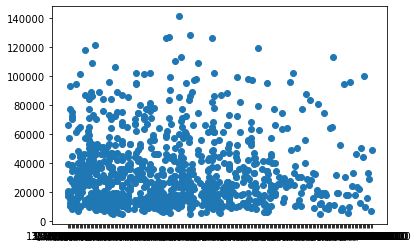

In [6]:
fig,ax = plt.subplots()
ax.scatter(df["saledate"][:1000],df["SalePrice"][:1000])

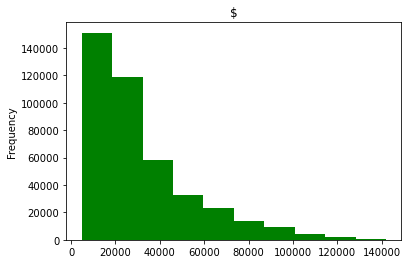

In [6]:
df.SalePrice.plot.hist(color="green",title="$");

### Parsing dates

When we work with time series data, we want to enrich the time & date component as much as possible.

We can do that by telling pandas which of our columns has dates in it using the `parse_dates` parameter.

In [7]:
# Import data again but this time parse dates
df = pd.read_csv("data/TrainAndValid.csv",low_memory=False,parse_dates=["saledate"])

In [8]:
df.saledate.dtype

dtype('<M8[ns]')

In [9]:
df.saledate[:1000]

0     2006-11-16
1     2004-03-26
2     2004-02-26
3     2011-05-19
4     2009-07-23
         ...    
995   2009-07-16
996   2007-06-14
997   2005-09-22
998   2005-07-28
999   2011-06-16
Name: saledate, Length: 1000, dtype: datetime64[ns]

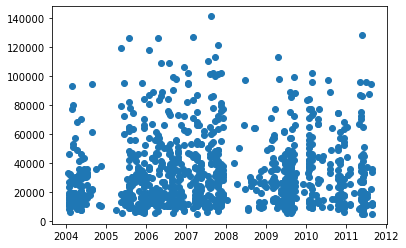

In [10]:
fig,ax = plt.subplots()
ax.scatter(df["saledate"][:1000],df["SalePrice"][:1000])

In [11]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000,57000,10000,38500,11000
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68,4640,2838,3486,722
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


### Sort DataFrame by saledate

When working with time series data, it's a good idea to sort it by date.

In [13]:
# Sort DataFrame in date order
df.sort_values(by=["saledate"],inplace=True,ascending=True)

In [14]:
df.saledate.head()

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
Name: saledate, dtype: datetime64[ns]

### Make a copy of the original DataFrame

We make a copy of the original dataframe so when we manipulate the copy, we've still got our original data.

In [15]:
# Make copy 
df_tmp = df.copy()

In [16]:
df_tmp

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410879,6302984,16000.0,1915521,5266,149,99.0,2001,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN
412476,6324811,6000.0,1919104,19330,149,99.0,2004,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
411927,6313029,16000.0,1918416,17244,149,99.0,2004,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
407124,6266251,55000.0,509560,3357,149,99.0,1993,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
## Add datetime paramters for saledate column
df_tmp["saleYear"] = df_tmp.saledate.dt.year
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDay"] = df_tmp.saledate.dt.day
df_tmp["saleDatOfWeek"] = df_tmp.saledate.dt.dayofweek
df_tmp["saleDayOfYear"] = df_tmp.saledate.dt.dayofyear

In [18]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500,14000,50000,16000,22000
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18,99,99,99,99
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


In [19]:
# Now we've enriched our dataframe with datetime features,we can remove saledate
df_tmp.drop("saledate",axis=1,inplace=True)

In [20]:
# Check the values of different columns
df_tmp.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Iowa               1336
Montana            1336
Oklahoma           1326
Nebraska            866
West Virginia   

## 5. Modelling 

We've done enough EDA (we could always do more) but let's start to do some model-driven EDA.

In [21]:
# Let's build a machine learning model 
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1,
                              random_state=42)

model.fit(df_tmp.drop("SalePrice", axis=1), df_tmp["SalePrice"])

ValueError: could not convert string to float: 'Low'

In [22]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   fiModelDesc               412698 non-null  object 
 10  fiBaseModel               412698 non-null  object 
 11  fiSecondaryDesc           271971 non-null  object 
 12  fiModelSeries             58667 non-null   object 
 13  fiModelDescriptor         74816 non-nul

In [23]:
df_tmp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

### Convert string to categories

One way we can turn all of our data into numbers is by converting them into pandas catgories.

We can check the different datatypes compatible with pandas here: https://pandas.pydata.org/pandas-docs/stable/reference/general_utility_functions.html#data-types-related-functionality

In [24]:
pd.api.types.is_string_dtype(df_tmp["UsageBand"])

True

In [25]:
# Find the columns which contain strings
for label,content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [26]:
# This will turn all of the string value into category values
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype("category").cat.as_ordered()

In [27]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

In [28]:
df_tmp.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

Thanks to pandas Categories we now have a way to access all of our data in the form of numbers.

But we still have a bunch of missing data...

In [29]:
# Check missing data
df_tmp.isnull().sum()/len(df_tmp)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

In [30]:
# Export current tmp dataframe
df_tmp.to_csv("data/train_tmp.csv",
              index=False)

In [31]:
# Import preprocessed data
df_tmp = pd.read_csv("data/train_tmp.csv",
                     low_memory=False)
df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500,14000,50000,16000,22000
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18,99,99,99,99
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


## Fill missing values 

### Fill numerical missing values first

In [32]:
for label,content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDay
saleDatOfWeek
saleDayOfYear


In [33]:
df_tmp.ModelID

0          8434
1         10150
2          4139
3          8591
4          4089
          ...  
412693     5266
412694    19330
412695    17244
412696     3357
412697     4701
Name: ModelID, Length: 412698, dtype: int64

In [34]:
# Check fo which numeric columns have null values
for label,content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)
        

auctioneerID
MachineHoursCurrentMeter


In [35]:
# Fill numeric rows with the median
for label,content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column which tell us if the data was missing
            df_tmp[label+"_is_missing"] = pd.isnull(content)
            # Fill missing numeric values with median
            df_tmp[label] = content.fillna(content.median())
        

In [37]:
# Demonstarte how median is more robust than mean
hundreds = np.full((1000),100)
hundreds_billion = np.append(hundreds,1000000000)
np.mean(hundreds),np.mean(hundreds_billion),np.median(hundreds),np.median(hundreds_billion)

(100.0, 999100.8991008991, 100.0, 100.0)

In [39]:
for label,content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            
            print(label)

In [40]:
# Check to see how many examples were missing
df_tmp["auctioneerID_is_missing"].value_counts()

False    392562
True      20136
Name: auctioneerID_is_missing, dtype: int64

In [41]:
df_tmp.isna().sum()

SalesID                                     0
SalePrice                                   0
MachineID                                   0
ModelID                                     0
datasource                                  0
auctioneerID                                0
YearMade                                    0
MachineHoursCurrentMeter                    0
UsageBand                              339028
fiModelDesc                                 0
fiBaseModel                                 0
fiSecondaryDesc                        140727
fiModelSeries                          354031
fiModelDescriptor                      337882
ProductSize                            216605
fiProductClassDesc                          0
state                                       0
ProductGroup                                0
ProductGroupDesc                            0
Drive_System                           305611
Enclosure                                 334
Forks                             

In [42]:
### Filling and turning categorical variables into numbers
for label,content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [47]:
# Turn categorical variables into numbers and fill missing
for label,content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to indicate whether sample had missing value
        df_tmp[label+"is_missing"]=pd.isnull(content)
        # Turn categories into numbers and add+1
        df_tmp[label] = pd.Categorical(content).codes+1

In [49]:
pd.Categorical(df_tmp.state).codes+1

array([44,  9,  9, ...,  5,  5,  5], dtype=int8)

In [54]:
df_tmp.isna().sum()[:20]

SalesID                     0
SalePrice                   0
MachineID                   0
ModelID                     0
datasource                  0
auctioneerID                0
YearMade                    0
MachineHoursCurrentMeter    0
UsageBand                   0
fiModelDesc                 0
fiBaseModel                 0
fiSecondaryDesc             0
fiModelSeries               0
fiModelDescriptor           0
ProductSize                 0
fiProductClassDesc          0
state                       0
ProductGroup                0
ProductGroupDesc            0
Drive_System                0
dtype: int64

In [51]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Columns: 103 entries, SalesID to Steering_Controlsis_missing
dtypes: bool(46), float64(3), int16(4), int64(10), int8(40)
memory usage: 77.9 MB


In [52]:
df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500,14000,50000,16000,22000
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mountingis_missing,False,True,False,True,False
Blade_Typeis_missing,False,True,False,True,False
Travel_Controlsis_missing,False,True,False,True,False
Differential_Typeis_missing,True,False,True,False,True


Now that all of data is numeric as well as our dataframe has no missing values, we should be able to build a machine learning model.

In [56]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Undercarriage_Pad_Widthis_missing,Stick_Lengthis_missing,Thumbis_missing,Pattern_Changeris_missing,Grouser_Typeis_missing,Backhoe_Mountingis_missing,Blade_Typeis_missing,Travel_Controlsis_missing,Differential_Typeis_missing,Steering_Controlsis_missing
0,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,0,4593,...,True,True,True,True,True,False,False,False,True,True
1,1821514,14000.0,1194089,10150,132,99.0,1980,0.0,0,1820,...,True,True,True,True,True,True,True,True,False,False
2,1505138,50000.0,1473654,4139,132,99.0,1978,0.0,0,2348,...,True,True,True,True,True,False,False,False,True,True
3,1671174,16000.0,1327630,8591,132,99.0,1980,0.0,0,1819,...,True,True,True,True,True,True,True,True,False,False
4,1329056,22000.0,1336053,4089,132,99.0,1984,0.0,0,2119,...,True,True,True,True,True,False,False,False,True,True


In [58]:
%%time
# Instantiate our model
model = RandomForestRegressor(n_jobs=-1,random_state=42)
model.fit(df_tmp.drop("SalePrice",axis=1),df_tmp["SalePrice"])


Wall time: 5min 8s


RandomForestRegressor(n_jobs=-1, random_state=42)

In [59]:
# Let's score 
model.score(df_tmp.drop("SalePrice",axis=1),df_tmp["SalePrice"])

0.9875468079970562

Question: Why doesn't the above metric hold water? (why isn't the metric reliable)

Splitting data into train/validation sets

In [64]:
df_tmp.saleYear.value_counts()

2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: saleYear, dtype: int64

In [67]:
df_val = df_tmp[df_tmp["saleYear"]==2012]
df_train = df_tmp[df_tmp.saleYear!=2012]
len(df_train),len(df_val)

(401125, 11573)

In [72]:
# Split data into X and y
X_train,y_train = df_train.drop("SalePrice",axis=1),df_train.SalePrice
X_valid,y_valid = df_val.drop("SalePrice",axis=1),df_val.SalePrice
X_train.shape,X_valid.shape,y_train.shape,y_valid.shape

((401125, 102), (11573, 102), (401125,), (11573,))

In [73]:
y_train

0          9500.0
1         14000.0
2         50000.0
3         16000.0
4         22000.0
           ...   
401120    29000.0
401121    11000.0
401122    11000.0
401123    18000.0
401124    13500.0
Name: SalePrice, Length: 401125, dtype: float64

In [74]:
y_valid

401125    46173.2
401126    66000.0
401127    26800.0
401128    42100.0
401129    62100.0
           ...   
412693    16000.0
412694     6000.0
412695    16000.0
412696    55000.0
412697    34000.0
Name: SalePrice, Length: 11573, dtype: float64

# Evaluation function


In [85]:
# Evaluation function
from sklearn.metrics import mean_squared_log_error,mean_absolute_error,r2_score
def rmsle(y_test,y_preds):
    return np.sqrt(mean_squared_log_error(y_test,y_preds))
# Create function to evaluate model on a few different levels
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {
        "Training MAE": mean_absolute_error(y_train,train_preds),
        "Valid MAE":mean_absolute_error(y_valid,val_preds),
        "Training RMSLE": rmsle(y_train,train_preds),
        "Valid RMSLE": rmsle(y_valid,val_preds),
        "Training R^2": r2_score(y_train,train_preds),
        "Valid R^2": r2_score(y_valid,val_preds)
    }
    return scores

## Testing our model on a subset (to tune the hyperparameters)

In [86]:
# # This takes far too long... for experimenting

# %%time
# model = RandomForestRegressor(n_jobs=-1, 
#                               random_state=42)

# model.fit(X_train, y_train)

In [87]:
len(X_train)

401125

In [88]:
%%time
# Change max_samples values
model = RandomForestRegressor(n_jobs=-1,random_state=42,max_samples=10000)
model.fit(X_train,y_train)
show_scores(model)

Wall time: 16.2 s


{'Training MAE': 5561.2988092240585,
 'Valid MAE': 7177.26365505919,
 'Training RMSLE': 0.257745378256977,
 'Valid RMSLE': 0.29362638671089003,
 'Training R^2': 0.8606658995199189,
 'Valid R^2': 0.8320374995090507}

### Hyerparameter tuning with RandomizedSearchCV

In [92]:
%%time
from sklearn.model_selection import RandomizedSearchCV
# Different RandomForestRegressor hyperparameters
rf_grid = {
    "n_estimators":np.arange(10,100,10),
    "max_depth":[None,3,5,10],
    "min_samples_split":np.arange(1,20,2),
    "min_samples_leaf":np.arange(1,20,2),
    "max_features": [0.5,1,"sqrt","auto"],
    "max_samples":[10000]
}
# Instanciate RandomizedSearchCV
rs_model = RandomizedSearchCV(
RandomForestRegressor(n_jobs=-1,
                     random_state=42),
                    param_distributions = rf_grid,
                     n_iter=2,
                    cv=5,
                    verbose=True)
rs_model.fit(X_train,y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.2min finished


Wall time: 1min 19s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=2,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [93]:
rs_model.best_params_

{'n_estimators': 60,
 'min_samples_split': 15,
 'min_samples_leaf': 7,
 'max_samples': 10000,
 'max_features': 'auto',
 'max_depth': 10}

In [94]:
# Evaluate the Randomized Search model
show_scores(rs_model)

{'Training MAE': 6553.669252735424,
 'Valid MAE': 7964.308186996509,
 'Training RMSLE': 0.2938485770510881,
 'Valid RMSLE': 0.31758529724260015,
 'Training R^2': 0.8124672329708421,
 'Valid R^2': 0.7903071797184406}

### Train a model with the best hyperparamters

**Note:** These were found after 100 iterations of `RandomizedSearchCV`.

In [95]:
%%time
# Most ideal hyperparameters
ideal_model=RandomForestRegressor(n_estimators=40,
                                 min_samples_leaf=1,
                                 min_samples_split=14,
                                 max_features=0.5,
                                 n_jobs=-1,
                                 max_samples=None,
                                 random_state=42)
ideal_model.fit(X_train,y_train)

Wall time: 1min 15s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1)

In [96]:
# Score for ideal model
show_scores(ideal_model)

{'Training MAE': 2951.2396850768496,
 'Valid MAE': 5955.7937915546245,
 'Training RMSLE': 0.14454803676840944,
 'Valid RMSLE': 0.24733304800557346,
 'Training R^2': 0.9589918667491721,
 'Valid R^2': 0.88198590315309}

In [97]:
# Score for rs_model
show_scores(rs_model)

{'Training MAE': 6553.669252735425,
 'Valid MAE': 7964.308186996509,
 'Training RMSLE': 0.2938485770510881,
 'Valid RMSLE': 0.3175852972426002,
 'Training R^2': 0.8124672329708421,
 'Valid R^2': 0.7903071797184406}

In [124]:
# Making predictions on test data
# Import test data
df_test = pd.read_csv("data/Test.csv",low_memory=False,parse_dates=["saledate"])
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [125]:
# Making predictions
test_preds = ideal_model.predict(df_test)

ValueError: could not convert string to float: 'Low'

In [126]:
df_test.isna().sum()

SalesID                         0
MachineID                       0
ModelID                         0
datasource                      0
auctioneerID                    0
YearMade                        0
MachineHoursCurrentMeter    10328
UsageBand                   10623
saledate                        0
fiModelDesc                     0
fiBaseModel                     0
fiSecondaryDesc              3975
fiModelSeries               10451
fiModelDescriptor            9433
ProductSize                  6409
fiProductClassDesc              0
state                           0
ProductGroup                    0
ProductGroupDesc                0
Drive_System                 9698
Enclosure                       2
Forks                        6149
Pad_Type                    10349
Ride_Control                 8216
Stick                       10349
Transmission                 7639
Turbocharged                10349
Blade_Extension             11806
Blade_Width                 11806
Enclosure_Type

In [127]:
df_test.saledate

0       2012-05-03
1       2012-05-10
2       2012-05-10
3       2012-05-10
4       2012-05-10
           ...    
12452   2012-10-24
12453   2012-10-24
12454   2012-10-24
12455   2012-10-24
12456   2012-09-19
Name: saledate, Length: 12457, dtype: datetime64[ns]

### Preprocessing the data (getting the test dataset in the same format as our training dataset)

In [128]:
def preprocess_data(df):
    """
    Performs transformations on df and returns transformed df.
    """
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayOfWeek"] = df.saledate.dt.dayofweek
    df["saleDayOfYear"] = df.saledate.dt.dayofyear
    
    df.drop("saledate", axis=1, inplace=True)
    
    # Fill the numeric rows with median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # Add a binary column which tells us if the data was missing or not
                df[label+"_is_missing"] = pd.isnull(content)
                # Fill missing numeric values with median
                df[label] = content.fillna(content.median())
    
        # Filled categorical missing data and turn categories into numbers
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"] = pd.isnull(content)
            # We add +1 to the category code because pandas encodes missing categories as -1
            df[label] = pd.Categorical(content).codes+1
    
    return df

In [129]:
# Process test data
df_test = preprocess_data(df_test)
df_test.head().T

,0,1,2,3,4
SalesID,1227829,1227844,1227847,1227848,1227863
MachineID,1006309,1022817,1031560,56204,1053887
ModelID,3168,7271,22805,1269,22312
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
...,...,...,...,...,...
Backhoe_Mounting_is_missing,True,True,True,True,False
Blade_Type_is_missing,True,True,True,True,False
Travel_Controls_is_missing,True,True,True,True,False
Differential_Type_is_missing,True,False,True,True,True


In [130]:
# Make predictions on updated df
test_preds = ideal_model.predict(df_test)

ValueError: Number of features of the model must match the input. Model n_features is 102 and input n_features is 101 

In [131]:
X_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Widthis_missing,Stick_Lengthis_missing,Thumbis_missing,Pattern_Changeris_missing,Grouser_Typeis_missing,Backhoe_Mountingis_missing,Blade_Typeis_missing,Travel_Controlsis_missing,Differential_Typeis_missing,Steering_Controlsis_missing
0,1646770,1126363,8434,132,18.0,1974,0.0,0,4593,1744,...,True,True,True,True,True,False,False,False,True,True
1,1821514,1194089,10150,132,99.0,1980,0.0,0,1820,559,...,True,True,True,True,True,True,True,True,False,False
2,1505138,1473654,4139,132,99.0,1978,0.0,0,2348,713,...,True,True,True,True,True,False,False,False,True,True
3,1671174,1327630,8591,132,99.0,1980,0.0,0,1819,558,...,True,True,True,True,True,True,True,True,False,False
4,1329056,1336053,4089,132,99.0,1984,0.0,0,2119,683,...,True,True,True,True,True,False,False,False,True,True


In [132]:
# We can find how the columns differ using sets
set(X_train.columns)-set(df_test.columns)

{'Backhoe_Mountingis_missing',
 'Blade_Extensionis_missing',
 'Blade_Typeis_missing',
 'Blade_Widthis_missing',
 'Coupler_Systemis_missing',
 'Coupleris_missing',
 'Differential_Typeis_missing',
 'Drive_Systemis_missing',
 'Enclosure_Typeis_missing',
 'Enclosureis_missing',
 'Engine_Horsepoweris_missing',
 'Forksis_missing',
 'Grouser_Tracksis_missing',
 'Grouser_Typeis_missing',
 'Hydraulics_Flowis_missing',
 'Hydraulicsis_missing',
 'Pad_Typeis_missing',
 'Pattern_Changeris_missing',
 'ProductGroupDescis_missing',
 'ProductGroupis_missing',
 'ProductSizeis_missing',
 'Pushblockis_missing',
 'Ride_Controlis_missing',
 'Ripperis_missing',
 'Scarifieris_missing',
 'Steering_Controlsis_missing',
 'Stick_Lengthis_missing',
 'Stickis_missing',
 'Thumbis_missing',
 'Tip_Controlis_missing',
 'Tire_Sizeis_missing',
 'Track_Typeis_missing',
 'Transmissionis_missing',
 'Travel_Controlsis_missing',
 'Turbochargedis_missing',
 'Undercarriage_Pad_Widthis_missing',
 'UsageBandis_missing',
 'auction

In [133]:
df_test["auctioneerID_is_missing"] = False
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


In [134]:
# Make predictions on the test data
test_preds = ideal_model.predict(df_test)

We've made some predictions but they're not in the same format Kaggle is asking for: https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

In [135]:
# Format predictions into the same format Kaggle is after
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalesPrice"] = test_preds
df_preds

,SalesID,SalesPrice
0,1227829,16977.549441
1,1227844,19946.065032
2,1227847,52393.001481
3,1227848,67721.081977
4,1227863,42531.519467
...,...,...
12452,6643171,41785.371399
12453,6643173,13343.349896
12454,6643184,15403.422525
12455,6643186,15742.906403


In [136]:
df_preds.to_csv("data/test_predictions.csv")

### Feature Importance

Feature importance seeks to figure out which different attributes of the data were most importance when it comes to predicting the **target variable** (SalePrice).

In [137]:
# Find feature importance of our best model
ideal_model.feature_importances_

array([3.14310524e-02, 1.60998039e-02, 4.99756194e-02, 1.88241173e-03,
       3.33174934e-03, 2.00950543e-01, 3.33340158e-03, 1.02811564e-03,
       4.26770527e-02, 4.25393124e-02, 6.72210945e-02, 4.87318654e-03,
       2.63090833e-02, 1.67645817e-01, 4.22218330e-02, 5.96637577e-03,
       2.42420539e-03, 4.14908106e-03, 2.95203518e-03, 4.91203023e-02,
       1.76563609e-03, 1.34009017e-04, 9.78215445e-04, 2.13699703e-04,
       1.05359777e-03, 2.58493665e-05, 9.87458978e-05, 1.41298320e-02,
       4.07323650e-03, 6.03513131e-04, 4.43731679e-03, 6.00328944e-03,
       3.88651537e-03, 2.35468570e-03, 4.89712678e-04, 1.34688161e-02,
       8.57534586e-04, 1.02366933e-02, 7.22413465e-06, 7.99571292e-04,
       6.63765722e-04, 8.77493550e-04, 1.17108044e-03, 5.41509761e-04,
       5.66280291e-04, 3.21562512e-04, 2.05954701e-04, 2.31409314e-03,
       7.47841412e-04, 4.69526826e-04, 4.49925474e-04, 7.30391010e-02,
       3.77395871e-03, 5.74340680e-03, 2.89042916e-03, 9.87236792e-03,
      

In [138]:
# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))
    
    # Plot the dataframe
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

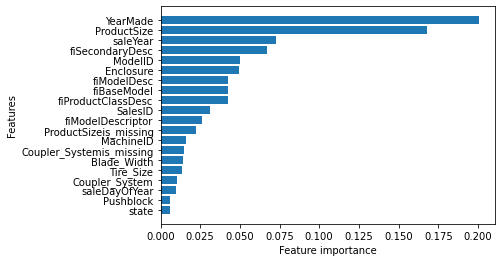

In [139]:
plot_features(X_train.columns, ideal_model.feature_importances_)

In [140]:
df["Enclosure"].value_counts()

OROPS                  177971
EROPS                  141769
EROPS w AC              92601
EROPS AC                   18
NO ROPS                     3
None or Unspecified         2
Name: Enclosure, dtype: int64

**Question to finish:** Why might knowing the feature importances of a trained machine learning model be helpful?

**Final challenge/extension:** What other machine learning models could you try on our dataset? 
**Hint:** https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html check out the regression section of this map, or try to look at something like CatBoost.ai or XGBooost.ai.